# Exploration 5. sound AI

# 1. 라벨 데이터 처리하기

In [18]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [6]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequecy, sampling_rate=16000, duration=1):
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

In [20]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [21]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[-2.6898393e-05 -2.7052371e-05 -3.8145350e-05 ...  3.1931957e-03
   3.1079133e-03  3.4319307e-03]
 [-1.2754685e-03 -8.4853591e-04 -1.2620051e-03 ...  2.7624101e-04
   2.2582090e-03  2.5904770e-03]
 [-6.4430013e-04  2.4587999e-03 -1.3987324e-03 ... -7.4375467e-04
   1.7703942e-03  3.6058074e-03]
 ...
 [-5.4226208e-02  1.6626543e-01  3.5990515e-01 ... -3.4939253e-01
   2.6216334e-02  2.0934777e-01]
 [ 2.1270107e-02  4.7006104e-02  6.0303599e-02 ...  3.1302709e-03
   3.0304642e-02 -2.7680099e-03]
 [ 3.3077584e-03  4.7082477e-03 -5.8659498e-06 ...  2.6214484e-03
   2.1198296e-03 -1.8074071e-03]]
✅


In [22]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


In [23]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj3/aiffel/speech_recognition/models/wav'

In [24]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [13]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


### MODEL

In [14]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

### lOSS

In [15]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


### TRAINING

In [16]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


### 학습결과 ### 학습결과 보기

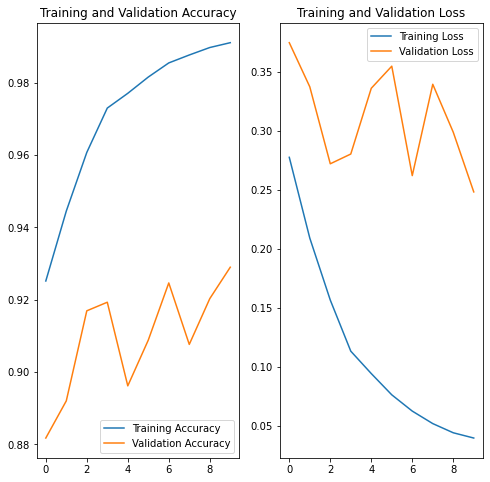

✅


In [28]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

### EVALUATION

In [29]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [ ]:
# 모델의 예측값과 실제값의 일치를 확인

In [30]:
results = model_wav.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 14s 91ms/step - loss: 0.2490 - accuracy: 0.9289
✅


In [31]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.249
accuracy value: 92.8882%
✅


### MODEL TEST

In [45]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  off


NameError: name 'ipd' is not defined

In [34]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: silence(Correct!)
✅


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

In [35]:
input_tensor = layers.Input(shape=(sr, 2))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 2)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     608         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [39]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [ ]:
# 체크포인트와 콜백 함수 추가

In [40]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [47]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9932
Epoch 00001: val_loss improved from inf to 0.28879, saving model to /home/aiffel-dj3/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 145s 102ms/step - loss: 0.0326 - accuracy: 0.9932 - val_loss: 0.2888 - val_accuracy: 0.9116
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9930
Epoch 00002: val_loss improved from 0.28879 to 0.26703, saving model to /home/aiffel-dj3/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 147s 104ms/step - loss: 0.0315 - accuracy: 0.9930 - val_loss: 0.2670 - val_accuracy: 0.9219
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9958
Epoch 00003: val_loss improved from 0.26703 to 0.23048, saving model to /home/aiffel-dj3/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] 

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

In [ ]:
# 학습결과의 시각화 및 evaluation

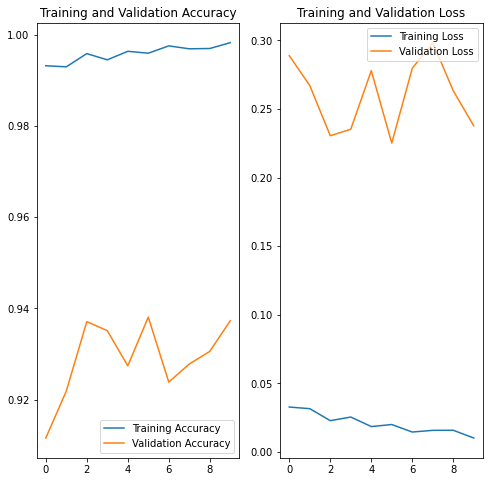

✅


In [55]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 6. Test dataset을 이용해서 모델의 성능을 평가

In [56]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f8c74953a50> and <tensorflow.python.keras.layers.pooling.MaxPooling1D object at 0x7f8c74959f90>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f8c6f8a2290> and <tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f8c74953a50>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f8c748f8f90> and <tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f8c6f8a2290>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7f8c748ff650> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f8c748ffa10>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.

ValueError: Shapes (9, 2, 32) and (9, 1, 32) are incompatible

In [ ]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

In [ ]:
# 테스트셋의 라벨과 모델의 실제 예측결과 비교하기

In [ ]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

In [ ]:
# 프로젝트를 마치며...

이번 프로젝트는 제출을 못할줄 알았는데, 그래도 제출이도 하는 것에 의의를 둔다. 
제가.... 몸살이 좀 심하게 걸려서 두통때문에 오래 붙잡고 있지를 못하겠네요..ㅠㅠ 
위에 epoch가 넘 오래걸려요... 저는 1시간 정도 걸려야 되더라구요... ㅠㅠ 
너무 감사합니다..! 